In [1]:
import cv2  # Still used for image I/O and adding noise
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV version:", cv2.__version__)

OpenCV version: 4.9.0


In [72]:

# Fourier Transformation Utility Functions using NumPy
def fft2(u):
    return np.fft.fftshift(np.fft.fft2(u))/(220)

def ifft2(u_hat):
    # return np.fft.ifft2(np.fft.ifftshift(u_hat)).real
    return 220*np.fft.ifft2(np.fft.ifftshift(u_hat))

# Backward and Central Fractional Derivatives
def Dx(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    array_x, array_y = np.mgrid[0:M,0:N]

    x = np.power(1 - np.exp(-1j*2*np.pi * array_x/M), alpha)
    ##K = np.power(complex_term, alpha)
    dx_hat = u_hat * x
    dx = ifft2(dx_hat)
    return dx

def Dy(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    array_x, array_y = np.mgrid[0:M,0:N]

    y = np.power(1 - np.exp(-1j*2*np.pi * array_y/N), alpha)
    ##K = np.power(complex_term, alpha)
    dy_hat = u_hat * y
    dy = ifft2(dy_hat)
    return dy

def Dx_central(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape

    size = M
    middle_row_index = size//2
    matrix = np.zeros((size, size), dtype=int)
    # if n is odd
    for i in range(middle_row_index):
        if (size%2) :
            matrix[i] = - size + i +1 + middle_row_index
        else :
            matrix[i] = - size + i + middle_row_index
    for i in range(middle_row_index + 1, size):
        matrix[i] = + i - middle_row_index 

    x = np.power(1 - np.exp(-1j*2*np.pi * matrix/M), alpha)
    z = np.power(np.exp(1j*np.pi * matrix/M), alpha)
    ##K = np.power(complex_term, alpha)
    dx_hat = u_hat * x * z
    dx = ifft2(dx_hat)
    # print("X central is ")
    # print(dx)
    return dx

def Dy_central(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    size = N
    array_x, array_y = np.mgrid[0:M,0:N]

    middle_row_index = size//2
    matrix = np.zeros((size, size), dtype=int)
    # if n is odd
    for i in range(middle_row_index):
        if (size%2) :
            matrix[:,i] = - size + i +1 + middle_row_index
        else :
            matrix[:,i] = - size + i + middle_row_index
    for i in range(middle_row_index + 1, size):
        matrix[:,i] = + i - middle_row_index 

    y = np.power(1 - np.exp(-1j*2*np.pi * matrix/N), alpha)
    z = np.power(np.exp(1j*np.pi * matrix/M), alpha)
    ##K = np.power(complex_term, alpha)
    dy_hat = u_hat * y * z
    dy = ifft2(dy_hat)
    # print("Y central is")
    # print(dy)
    return dy

# Diffusion Coefficient Computation
def C(u, alpha, beta):
    D = (np.square(Dx_central(u, alpha)) + np.square(Dy_central(u, alpha)))
    # mu_nn_numerator = np.square(Dx(u, beta)) * Dx(Dx(u, beta), beta) + 2 * Dx(u, beta) * Dy(u, beta) * Dx(Dy(u, beta), beta) + np.square(Dy(u, beta)) * Dy(Dy(u, beta), beta)
    # mu_nn_denominator = np.square(Dx(u, beta)) + np.square(Dy(u, beta)) + 0.001
    # mu_nn = mu_nn_numerator / mu_nn_denominator
    # mu_ee_numerator = np.square(Dx(u, beta)) * Dy(Dy(u, beta), beta) - 2 * Dx(u, beta) * Dy(u, beta) * Dx(Dy(u, beta), beta) + np.square(Dy(u, beta)) * Dx(Dx(u, beta), beta)
    # mu_ee_denominator = np.square(Dx(u, beta)) + np.square(Dy(u, beta)) + 0.001
    # mu_ee = mu_ee_numerator / mu_ee_denominator
    # fDC = np.abs(np.abs(mu_nn) - np.abs(mu_ee))
    c = 1 / (1 + D )
    return c

# Compute Kx and Ky using NumPy
def make_K(M, N, alpha):

    diagonal_matrix = np.diag(np.arange(M))
    diagonal_matrix = diagonal_matrix - (M/2)*np.eye(M)
    identityMatrix = np.eye(M)
    #w1_grid = np.fft.fftshift(np.fft.fftfreq(M) * M)
    #w2_grid = np.fft.fftshift(np.fft.fftfreq(N) * N)
    #complex_term_x = np.exp((1j * np.pi * w1_grid[:, None]) / M) - np.exp((-1j * np.pi * w1_grid[:, None]) / M)
    #complex_term_y = np.exp((1j * np.pi * w2_grid) / N) - np.exp((-1j * np.pi * w2_grid) / N)
    Kx = np.power(1 - np.exp(-1j*2*np.pi * diagonal_matrix/M), alpha)*np.power(np.exp(1j*np.pi * diagonal_matrix/M), alpha)
    Kx = Kx*identityMatrix
    #print(Kx)
    Ky = np.power(1 - np.exp(-1j*2*np.pi * diagonal_matrix/M), alpha)*np.power(np.exp(1j*np.pi * diagonal_matrix/M), alpha)
    Ky = Ky*identityMatrix
    #print(Ky)
    return Kx, Ky

In [73]:
# Simulation Parameters
alpha = 1.8
dt = np.power(0.25,alpha)
beta = 1.1

# Image Loading and Noise Addition
u_clean = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)
mean = 0
std = 20
noise = np.random.normal(mean, std, u_clean.shape)
u_noisy = u_clean + noise
u = u_noisy.copy()

# Compute Kx and Ky
M, N = u.shape
Kx, Ky = make_K(M, N, alpha)

# Denoising Loop
i = 0
prev_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
while True:
    i += 1
    print(f"Iteration {i}")

   # u_hat = np.fft.fftshift(np.fft.fft2(u))
    u_hat = fft2(u)
    c = C(u, alpha, beta)
    # print("C is")
    # print(c)
    gx = c * Dx_central(u, alpha)
    gy = c * Dy_central(u, alpha)

    gx_hat = fft2(gx)
    gy_hat = fft2(gy)

    # gx_hat = np.fft.fftshift(np.fft.fft2(gx))
    # gy_hat = np.fft.fftshift(np.fft.fft2(gy))

    # Compute the combined g_hat using the conjugates of Kx and Ky
    g_hat = (np.conj(Kx) @ gx_hat) + (np.conj(Ky) @ gy_hat)
    # print("G_HAT IS")
    # print(g_hat)

    # Perform iteration
    u_hat = u_hat - g_hat * dt
    u = ifft2(u_hat)
    # u = np.fft.ifft2(np.fft.ifftshift(u_hat)).real

    current_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
    if prev_PSNR > current_PSNR:
        break
    else:
        prev_PSNR = current_PSNR
        u_denoised = u.copy()  # Update denoised image after the loop

    u_denoised = u_denoised.real
    

Iteration 1
Iteration 2
Iteration 3


/var/folders/cm/zggbcn3n4f7b1gpjb5xkknnw0000gn/T/ipykernel_71972/631672479.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  current_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))


Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteration 78
Iteration 79
Iteration 80
Itera

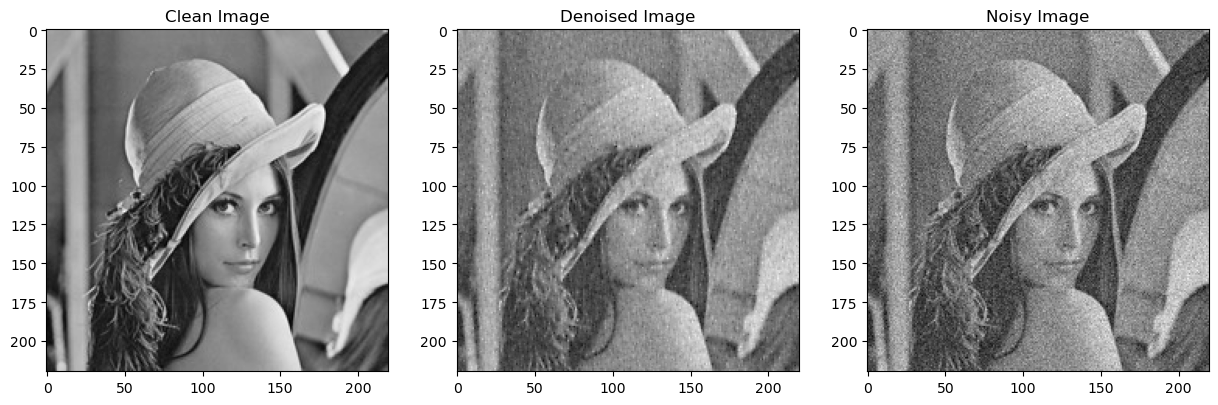

The arrays have different values.
Mean absolute difference: 11.6847701727962
Maximum absolute difference: 47.125320809356964
Minimum absolute difference: 2.6040712718611303e-05
Mean absolute difference: 15.990526648735397
Maximum absolute difference: 86.94580443308362
Minimum absolute difference: 0.00015033135406383735


In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
ax1.imshow(u_clean, cmap='gray')
ax1.set_title('Clean Image')

# Plot the denoised image
ax2.imshow(u_denoised, cmap='gray')
ax2.set_title('Denoised Image')

# Plot the noisy image
ax3.imshow(u_noisy, cmap='gray')
ax3.set_title('Noisy Image')

plt.show()

if np.array_equal(u_denoised, u_noisy):
    print("The arrays have the same values.")
else:
    print("The arrays have different values.")

absolute_diff = np.abs(u_noisy - u_denoised)

# Calculate various statistics to quantify the difference
mean_abs_diff = np.mean(absolute_diff)
max_abs_diff = np.max(absolute_diff)
min_abs_diff = np.min(absolute_diff)

print("Mean absolute difference:", mean_abs_diff)
print("Maximum absolute difference:", max_abs_diff)
print("Minimum absolute difference:", min_abs_diff)

absolute_diff_ = np.abs(u_noisy - u_clean)

# Calculate various statistics to quantify the difference
mean_abs_diff_ = np.mean(absolute_diff_)
max_abs_diff_ = np.max(absolute_diff_)
min_abs_diff_ = np.min(absolute_diff_)

print("Mean absolute difference:", mean_abs_diff_)
print("Maximum absolute difference:", max_abs_diff_)
print("Minimum absolute difference:", min_abs_diff_)

In [68]:
u_clean

array([[161, 160, 161, ..., 164, 172, 143],
       [162, 161, 161, ..., 169, 178, 149],
       [161, 160, 160, ..., 134, 121,  90],
       ...,
       [ 49,  53,  52, ...,  71,  82,  88],
       [ 45,  50,  51, ...,  87,  99,  98],
       [ 44,  50,  49, ...,  96, 106, 104]], dtype=uint8)

In [76]:
u_noisy

array([[154.42323117, 187.34777944, 191.39509457, ..., 149.62727515,
        152.65523895, 179.76641368],
       [162.76206567, 200.31309796, 171.99323981, ..., 174.43153623,
        167.47358165, 167.41400759],
       [139.74793266, 175.91836755, 179.79252987, ..., 139.11212901,
         87.44506802, 101.69273956],
       ...,
       [ 61.14929792,  54.4211543 ,  64.23795375, ...,  74.51113068,
         88.55934438,  90.73912999],
       [ 34.37494361,  48.31950167,  48.63159719, ...,  67.68970089,
        113.95233852, 103.87458324],
       [ 80.76623126,  53.58176618,  31.07965413, ..., 101.09003857,
        111.51011158, 103.25557463]])

In [77]:
u_denoised

array([[140.06822485, 164.88381354, 183.60886898, ..., 134.86673859,
        146.07295451, 146.28801996],
       [168.14609516, 212.64173035, 169.75583943, ..., 173.5554072 ,
        147.48286592, 167.25826977],
       [144.85729812, 174.18990569, 176.27038285, ..., 123.70842186,
        100.41813805, 111.14117902],
       ...,
       [ 50.34447762,  53.83597719,  67.68575909, ...,  69.7450521 ,
         86.20514764,  90.39597577],
       [ 42.64992333,  51.50964886,  55.50335103, ...,  73.63609565,
        102.83467228, 104.95379081],
       [ 90.07270323,  70.19256057,  37.3674292 , ..., 113.59737696,
        137.21294819, 125.40919596]])